# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [1]:
!pip install torch numpy Pillow torchsummary torchvision matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [3]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 1)
    
    # Create a new image from the converted array
    converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image) * 255, transforms.ToTensor()(lesion_free_image) * 255, transforms.ToTensor()(converted_image)

In [4]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Module 2: Normal Appearance Autoencoder

In [5]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, max_pool=True):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-3)
        self.relu2 = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(2, 2) if max_pool else None
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        if self.maxpool is not None:
            x = self.maxpool(x)
        return x


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            nn.Dropout(0.2),
            ConvBlock(8, 16, kernel_size=3),
            nn.Dropout(0.2),
            ConvBlock(16, 32, kernel_size=3, max_pool=False),
            nn.Dropout(0.2),
            ConvBlock(32, 64, kernel_size=3, max_pool=False),
            nn.Dropout(0.2),
            ConvBlock(64, 128, kernel_size=3, max_pool=False),
            nn.Dropout(0.2)
        )
        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.mean_relu = nn.ReLU()
        self.logvar_relu = nn.ReLU()
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(128, 64, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(64, 32, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(32, 16, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(16, 8, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(8, 3, kernel_size=3, max_pool=False),
        )
        self.final = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mean + eps*std
        else:
            return mean
        
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        x = self.final(x)
        return x, mean, logvar

In [6]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 1079007
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              80
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3          [-1, 8, 256, 256]             584
       BatchNorm2d-4          [-1, 8, 256, 256]              16
         LeakyReLU-5          [-1, 8, 256, 256]               0
         MaxPool2d-6          [-1, 8, 128, 128]               0
         ConvBlock-7          [-1, 8, 128, 128]               0
           Dropout-8          [-1, 8, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           1,168
      BatchNorm2d-10         [-1, 16, 128, 128]              32
           Conv2d-11         [-1, 16, 128, 128]           2,320
      BatchNorm2d-12         [-1, 16, 128, 128]              32
        LeakyReLU-13         [-1, 16, 128, 128]               0


In [7]:
from torch.optim.lr_scheduler import ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)
num_epochs = 50

def loss_function(recon_x, input, target, mu, logvar, weight_map):  
  alpha = 0.001
  REC = F.binary_cross_entropy(recon_x, target, reduction='none') * weight_map
  REC = REC.view(REC.size(0), -1).mean()
  REG = alpha * F.binary_cross_entropy(model.encode(input), model.encode(target), reduction='none')
  REG = REG.view(REG.size(0), -1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return REC + REG + KLD

print("Training begins!")

for epoch in range(num_epochs):
  print(f"Epoch {epoch} begins:")
  model.train()
  with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      weight_map = weight_map.to(device)
      recon, mu, logvar = model(lesion)
      loss = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
      loss.backward()
      optimizer.step()
      
      if batch_idx % 20 == 0:
        tepoch.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}")
        tepoch.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

  model.eval()
  
  with torch.no_grad():
    with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
      for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        weight_map = weight_map.to(device)
        recon, mu, logvar = model(lesion)
        loss = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
        if batch_idx % 20 == 0:
          tepoch.set_description(f"Validation loss: {loss / len(lesion)}")


Training begins!
Epoch 0 begins:


  0%|          | 0/29 [00:00<?, ?batch/s]../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [65,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [67,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [68,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [74,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [77,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [83,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:92: operator(): block: [369,0,0], thread: [84,

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free) in enumerate(tepoch):
      print(lesion.max(), lesion.min())
      break

  0%|          | 0/8 [00:00<?, ?batch/s]

tensor(1.) tensor(0.)


Validation loss: 17837.314453125:   0%|          | 0/8 [00:00<?, ?batch/s]

0.0 255.0
0.0 255.0
0.5167389 0.69386655


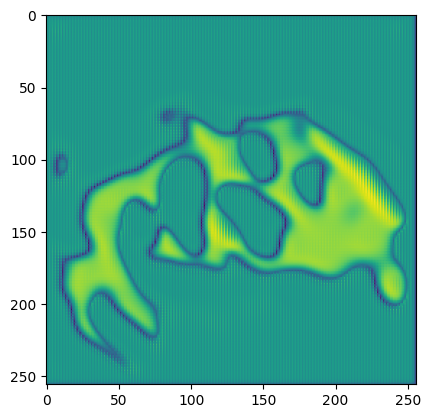

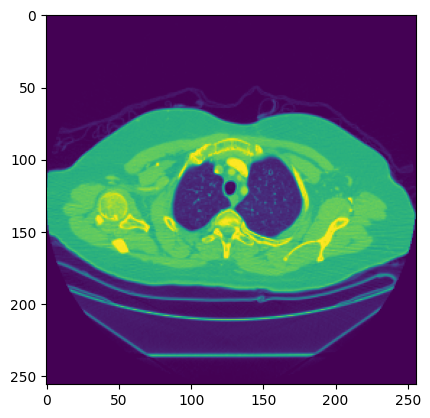

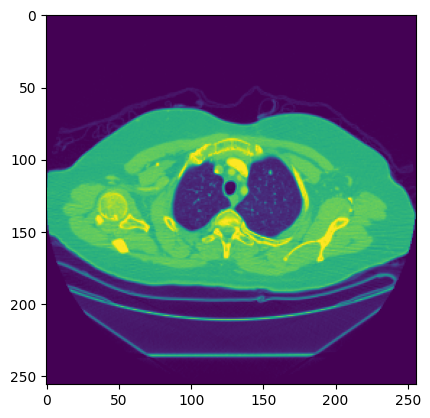

Validation loss: 17837.314453125:   0%|          | 0/8 [00:00<?, ?batch/s]


In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon[0][0].cpu().numpy().min(), recon[0][0].cpu().numpy().max())
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

Validation loss: 1967.2447509765625:   0%|          | 0/8 [00:00<?, ?batch/s]

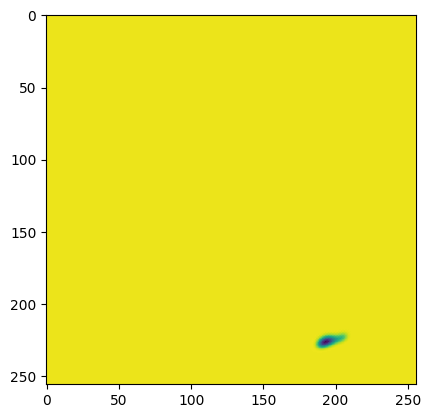

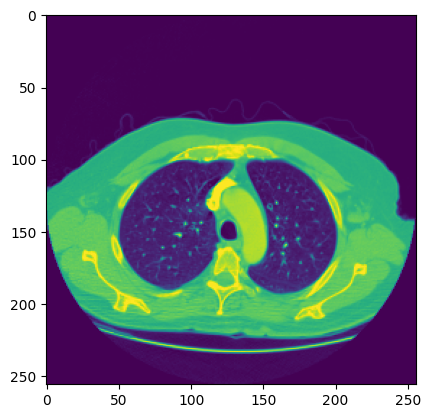

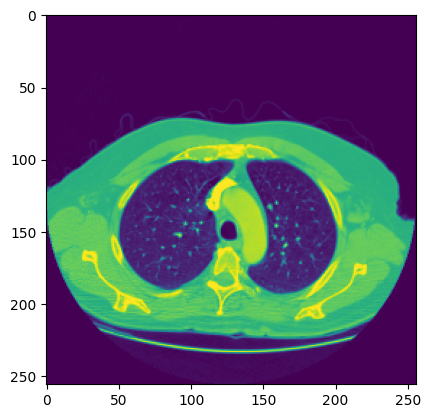

Validation loss: 1967.2447509765625:   0%|          | 0/8 [00:00<?, ?batch/s]


In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

## Module 3: Prior UNet